# Exercise 1

In [1]:
import networkx as nx
from copy import deepcopy
import random
from pprint import pprint
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
	os.mkdir('results')
except:
	pass
try:
	os.mkdir('fig')
except:
	pass

In [3]:
E = {
	'o':{
		'a':2/5,
		'b':1/5
	},
	'a':{
		'b':3/4,
		'c':1/4
	},
	'b':{
		'o':1/2,
		'c':1/2
	},
	'c':{
		'b':1/3,
		'd':2/3
	},
	'd':{
		'a':1/3,
		'c':1/3
	}
}

In [4]:
DG = nx.DiGraph()
edge_list = [(u,v,w) for u,e in E.items() for v,w in e.items()]
DG.add_weighted_edges_from(edge_list)

In [5]:
W = nx.adjacency_matrix(DG).toarray()
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W
indices = dict()
for i in range(len(DG.nodes)):
    indices[list(DG.nodes)[i]] = i

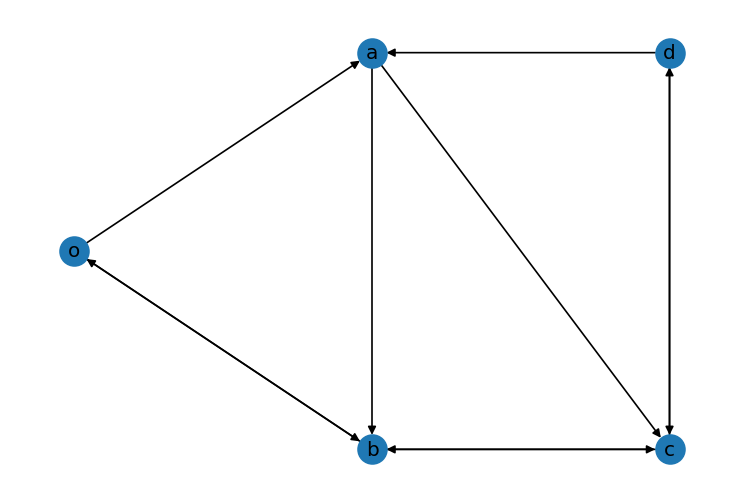

In [6]:
pos = {
    'o':[0,-1],
    'a':[2,0],
    'b':[2,-2],
    'd':[4,0],
	'c':[4,-2]
}
plt.figure(dpi=120)
# draw_labels(DG)
nx.draw(DG, pos, with_labels=True) #, connectionstyle="arc3,rad=0.2")
plt.savefig('fig/graph1.png')

In [7]:
# function that simulates a move and returns time taken and destination
def move(G, v):
	w = degrees[indices[v]]
	t = random.expovariate(w) # time to wait before moving from node v
	x = random.random()
	# *w # w is for normalization, in this way x can be used as in Hint 2
	c = 0 # used to compute cumulative distribution
	for u,e in G[v].items():
		c += e['weight']/w
		if x <= c: # lower bound found
			return t, u
	return t, u

Compute, by simulation, $\mathbf{E}_a[T_a^+]$

In [8]:
# Compute, by simulation, E_a[T_a^+]
def return_time(G, o, d, n_tests=int(1e4)):
	tt = 0
	for _ in range(n_tests):
		u = o
		while True:
			t, u = move(G, u)
			tt += t
			if u == d:
				break
	return tt/n_tests


In [9]:
estimation = f"{return_time(DG,'a','a',n_tests=int(1e4)):.2f}"
print(estimation)
with open('results/rt.txt', 'w') as outf:
	outf.write(estimation)

6.74


In [10]:
def dominant_eigenvector(P):
	l,v = np.linalg.eig(P)
	for i in range(len(l)):
		if np.isclose(l[i], 1):
			v = v[:,i].real
			v = v/np.linalg.norm(v,ord=1)
			if v.sum() < 0:
				return -v
			return v

Computing $\overline{\pi}$

In [11]:
ws = max(degrees)
P_ = W + np.eye(len(DG.nodes)) - D
pi_ = dominant_eigenvector(np.array(P_).T)

Theoretical value of $\mathbf{E}_a[T_a^+]$

In [12]:
a = indices['a']
eata = 1/(degrees[a]*abs(pi_[a]))
print(f'{eata:.2f}')

6.75


Computing, by simulation, $\mathbf{E}_o[T_d]$

In [13]:
# Computing, by simulation, E_o[T_d]
estimation = f"{return_time(DG,'o','d'):.2f}"
print(estimation)
with open('results/ht.txt', 'w') as outf:
	outf.write(estimation)

8.82


### Theoretical computation of $\mathbf{E}_o[T_d]$
$\mathbf{E}_i[T_i] = 0$ \
$\mathbf{E}_i[T_d] = \dfrac{1}{w_i} + \sum_{j} P_{i,j} \mathbf{E}_j[T_d] \impliedby i \neq d$ \
$P := D^{-1} \Lambda$
$P_d : P_{d_{i,j}} = \begin{cases}
	P_{i,j} &\impliedby i \neq d \\
	0 &\impliedby i = d
\end{cases}$ \
$w\_inv_d = \begin{cases}
	\dfrac{1}{w_i} &\impliedby i \neq d \\
	0 &\impliedby i = d
\end{cases}$
$\mathbf{E}[T_d] = w\_inv_d + P_d \mathbf{E}[T_d] \implies (P_d - I) \mathbf{E}[T_d] = w\_inv_d $

In [14]:
def eotd(o, d):
	o = indices[o]
	d = indices[d]
	P_d = [[y/(wi) for y in x] for x,wi in zip(W,degrees)]
	w_inv_d = [1/wi for wi in degrees]
	P_d[d] = [0]*len(DG.nodes)
	w_inv_d[d] = 0
	for i in range(len(DG.nodes)):
		P_d[i][i] -= 1
	P_d = -np.array(P_d)
	w_inv_d = np.array(w_inv_d)
	e = np.linalg.solve(P_d, w_inv_d)
	return e

In [15]:
e = eotd('o','d')
print(f"{e[indices['o']]:.2f}")

8.79


## Second part

In [16]:
# French-DeGroot simulation
def fdg(P, x0, err_r=1e-3, n_iter=int(1e4)):
	for i in range(n_iter):
		x = P @ x0
		if np.linalg.norm(x-x0) < err_r * np.linalg.norm(x):
			return x
		x0 = x
	print('convergence not reached in', n_iter, 'iterations')
	return x

In [17]:
def aprint(a, ret=False):
	s = "[%s]"%(", ".join([f'{x:.2f}' for x in a]))
	print(s)
	if ret:
		return s

In [18]:
P = np.array([[y/wi for y in x] for x,wi in zip(W,degrees)])
x0 = np.random.rand(len(DG.nodes))
with open('results/x0.txt','w') as outf:
	outf.write(aprint(x0, ret=True))
b = fdg(P, x0)
aprint(b)
with open('results/consensus.txt','w') as outf:
	outf.write(f'{np.array(b).mean():.2f}')

[0.38, 0.43, 0.29, 0.40, 0.64]
[0.42, 0.42, 0.42, 0.42, 0.42]


The dynamics converge because the condensation graph has only one sink and it is aperiodic in the original graph

In [19]:
print(nx.strongly_connected.number_strongly_connected_components(DG))
print(nx.is_aperiodic(DG))

1
True


### Compute, by simulation, variance of consensus

In [20]:
def consensus_variance(P, mu, sigma, n_iter=int(1e3)):
	res = []
	for _ in range(n_iter):
		res.append(fdg(P,np.random.normal(mu, sigma, len(P))).mean())
	return np.var(res)

In [21]:
mu = 0.8
sigma = 0.3

estimation = f'{consensus_variance(P, mu, sigma):.3f}'
print(estimation)
with open('results/consensus_variance.txt', 'w') as outf:
	outf.write(estimation)

0.018


### Theoretical computation of variance of consensus

In [22]:
pi = dominant_eigenvector(P.T)
v = np.sum(np.square(pi)*(sigma**2))
print(f'{v:.3f}')

0.019


In [23]:
def remove_edges(G, edges):
	G = G.copy()
	for e in edges:
		G.remove_edge(*e)
		if G.out_degree[e[0]] == 0:
			# if there aren't any edges exiting from e[0], add a self loop
			G.add_weighted_edges_from([(e[0],e[0],1)])
	v = len(G.nodes)
	W = np.zeros((v,v))
	# compute matrix W
	for u,e in G.adj.items():
		for v,w in e.items():
			W[indices[u]][indices[v]] = w['weight']
	# compute matrix P
	P = W.copy()
	for i in range(P.shape[0]):
		P[i,:] /= W[i,:].sum()
	return G, W, P


In [24]:
DGG, WG, PG = remove_edges(DG, [('d','a'),('d','c')])

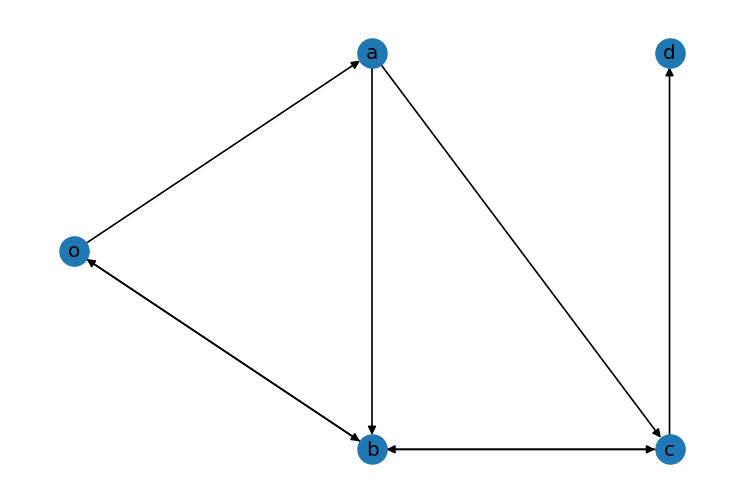

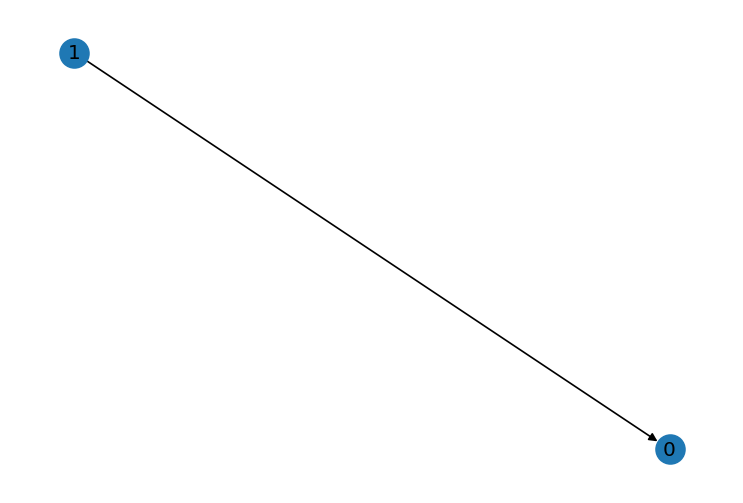

In [25]:
plt.figure(dpi=120)
nx.draw(DGG, pos, with_labels=True)
plt.savefig('fig/graph2.png')
plt.figure(dpi=120)
CDGG = nx.algorithms.components.condensation(DGG)
nx.draw(CDGG, with_labels=True)

Removing the outgoing edges from $d$, the graph is not strongly connected anymore. \
Now the asymptotic behaviour of the dynamics is determined only by the initial state of the nodes in the sinks of the condensation graph, because they are not influenced by the rest of the graph. Moreover, the sinks contain the support of the invariant distribution, which determines the consensus value. \
As in this case there is only one attracting component and it is aperiodic, a consensus will be reached, and its value will be the initial opinion of $d$.

In [26]:
def sink_aperiodicity(G):
	sinks = list(nx.algorithms.components.attracting_components(G))
	print('number of sinks:', len(sinks))
	print('is aperiodic:', all(nx.is_aperiodic(G.subgraph(t)) for t in sinks))

In [27]:
sink_aperiodicity(DGG)

number of sinks: 1
is aperiodic: True


In [28]:
mu = 0.8
sigma = 0.3
print(f'{consensus_variance(PG, mu, sigma):.4f}')
print(dominant_eigenvector(PG.T))

0.0896
[0. 0. 0. 0. 1.]


As $d$ is the only node affecting the asymptotic dynamics, the variance of the consensus equals the variance of the opinion of $d$.

In [29]:
DGH, WH, PH = remove_edges(DG, [('c','b'), ('d','a')])

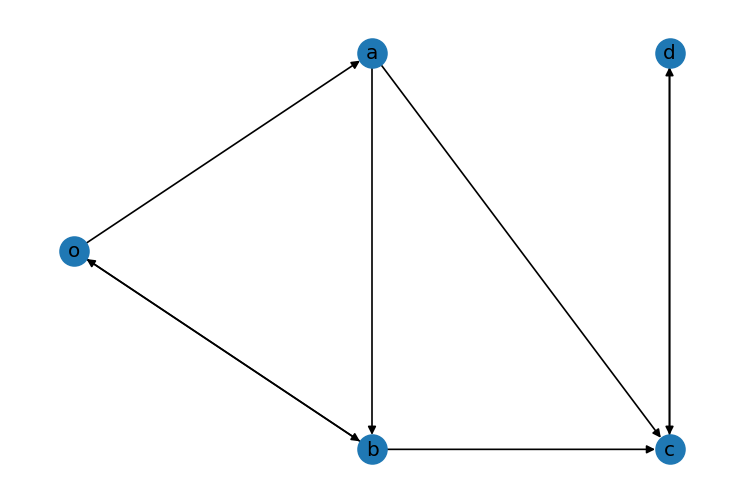

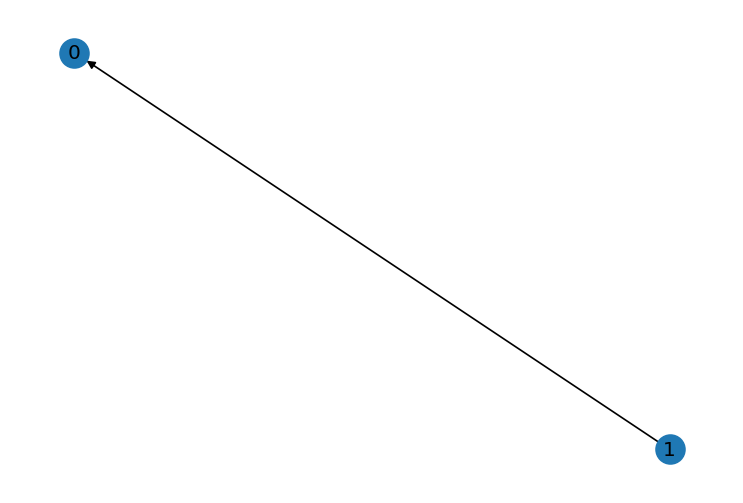

In [30]:
plt.figure(dpi=120)
nx.draw(DGH, pos, with_labels=True)
plt.savefig('fig/graph3.png')
plt.figure(dpi=120)
nx.draw(nx.condensation(DGH), with_labels=True)

This case is similar to the previous one, but in this case we have two nodes ($c$ and $d$) in the sink of the condensation graph (instead of only $d$). \
Now the attracting component is not aperiodic, so a consensus will (generally) not be reached.\
A consensus will be reached only in the cases where $x_c(0) = x_d(0)$

In [31]:
sink_aperiodicity(DGH)

number of sinks: 1
is aperiodic: False


In [32]:
x0 = np.random.rand(len(DGH.nodes))
# x0 = np.array([0,0,0,0.9,1])
print('Initial opinions:     ', end='')
aprint(x0)
x = fdg(PH, x0)
print('Simulation result:    ', end='')
aprint(x)

Initial opinions:     [0.26, 0.63, 0.16, 0.04, 0.31]
convergence not reached in 10000 iterations
Simulation result:    [0.16, 0.15, 0.25, 0.04, 0.31]
